In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from light_curve import GRB

In [4]:
# main dataframe with all info
df = GRB.lcdf

In [5]:
# dataframe with reference and target GRB info
newdf = pd.read_csv('data/new_distance_file.csv')

In [6]:
grbdf = newdf.loc[newdf.sigma < 5]

In [7]:
def delay_time(refname, tarname):
    ref = GRB(refname)
    tar = GRB(tarname)
    return abs(ref.get_trigger_time() - tar.get_trigger_time())

In [8]:
grbdf['delay'] = grbdf.apply(lambda x : delay_time(x['refGRBname'], x['name']), axis=1)

C:\Users\hhsud\AppData\Local\Temp\ipykernel_11672\1093293987.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grbdf['delay'] = grbdf.apply(lambda x : delay_time(x['refGRBname'], x['name']), axis=1)


### Plots of light curve with $\sigma < 3$
Legend : <br>
Blue = Reference <br>
Green = Target

In [15]:
def make_hist(ref, tar, info):
    df_ref = ref.timedf_from_fitfile()
    df_tar = tar.timedf_from_fitfile()

    start = -10
    end = max(ref.t90, tar.t90) + 10
    
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
    fig.suptitle(f'Distance : {info[0]}, Sigma : {info[1]}, Delay : {info[2]}', fontsize=16)
    
    ref_plt = axs[0].hist(df_ref.TTIME, bins=int((end - start)/ref.binsize), range=(start,end),
                label = ref.name, histtype='step', color='b')
    tar_plt = axs[1].hist(df_tar.TTIME, bins=int((end - start)/tar.binsize), range=(start,end),
                label = tar.name, histtype='step', color='g')
    
    ref_plt[2][0].set_xy(ref_plt[2][0].get_xy()[1:])
    tar_plt[2][0].set_xy(tar_plt[2][0].get_xy()[1:])
    ref_plt[2][0].set_xy(ref_plt[2][0].get_xy()[:-1])
    tar_plt[2][0].set_xy(tar_plt[2][0].get_xy()[:-1])
    
    plt.subplots_adjust(
        left=0.1,
        bottom=0.1, 
        right=0.9, 
        top=0.9, 
        wspace=0.4, 
        hspace=0
    )

    fig.legend(bbox_to_anchor=(0.4,0.6), borderaxespad=0, labels=[ref.name, tar.name], loc='center right')

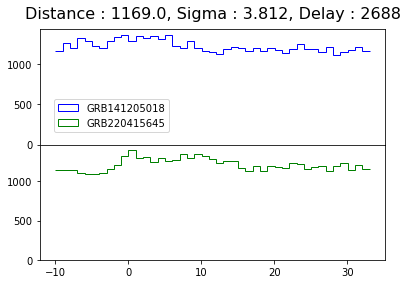

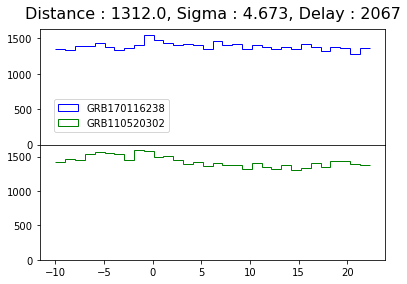

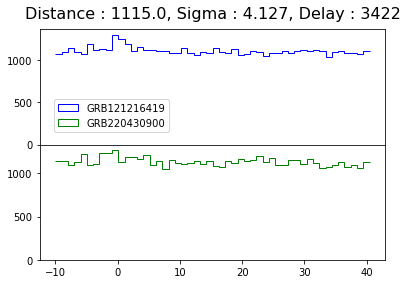

In [16]:
for i in range(grbdf.shape[0]):
    refname = grbdf.iloc[i]['refGRBname']
    tarname = grbdf.iloc[i]['name']
    tar = GRB(tarname)
    ref = GRB(refname)
    info = (grbdf.iloc[i].distance, grbdf.iloc[i].sigma, grbdf.iloc[i].delay.days)
    make_hist(ref, tar, info)

### Time delay vs $\sigma$

In [63]:
grbdf['delay_day'] = grbdf.delay.apply(lambda x : x.days)

C:\Users\hhsud\AppData\Local\Temp\ipykernel_20828\2583617598.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
fig = px.scatter(grbdf, x='delay_day', y=grbdf['sigma'], labels={'Delay_day':'Days'})
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 250
    ),
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 0.25
    )
)
fig.show()

### Distribution of delays

Text(0.5, 1.0, 'Delay Days Distribution, sigma < 5')

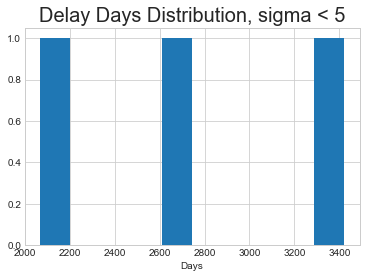

In [65]:
plt.hist(grbdf['delay_day'])
plt.xlabel('Days')
plt.title('Delay Days Distribution, sigma < 5', fontsize=20)